# Download data on Zenodo: https://zenodo.org/records/11150343

# Read the data

In [1]:
import pyreadr
import os
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
import geopandas as gpd
import numpy as np

In [2]:
strata = gpd.read_file('extracted_points_wgs84.gpkg')['Stratum'].to_numpy()
group_1c = (strata == 1)
group_ge2c = (strata == 2)
group_0c = (strata > 2)

In [3]:
count_1c = np.sum(group_1c.astype(int))
print(count_1c)
count_ge2c = np.sum(group_ge2c.astype(int))
print(count_ge2c)
count_0c = np.sum(group_0c.astype(int))
print(count_0c)
print(count_1c+count_ge2c+count_0c)
print(strata.shape)

2599
2599
46780
51978
(51978,)


In [4]:
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']
merged_agg_data_1c = np.full((count_1c*7,156), np.nan, dtype=np.double) 
merged_agg_data_ge2c = np.full((count_ge2c*7,156), np.nan, dtype=np.double) 
merged_agg_data_0c = np.full((count_0c*7,156), np.nan, dtype=np.double) 
merged_ARCO_data_1c = np.empty((count_1c*7,156), dtype=np.double) 
merged_ARCO_data_ge2c = np.empty((count_ge2c*7,156), dtype=np.double) 
merged_ARCO_data_0c = np.empty((count_0c*7,156), dtype=np.double) 

data = pyreadr.read_r('clear_agg.rds')[None].to_numpy()
clear_1c = data[group_1c]
clear_ge2c = data[group_ge2c]
clear_0c = data[group_0c]
mask_1c = (clear_1c == 1)
mask_ge2c = (clear_ge2c == 1)
mask_0c = (clear_0c == 1)
np.save('clear_1c', clear_1c)
np.save('clear_ge2c', clear_ge2c)
np.save('clear_0c', clear_0c)


for i, band in enumerate(bands):
    # Dividing by the scaling 250
    data = pyreadr.read_r(f'{band}_agg.rds')[None].to_numpy()/250.
    data_1c = data[group_1c]
    data_ge2c = data[group_ge2c]
    data_0c = data[group_0c]
    
    merged_agg_data_1c[i*count_1c:(i+1)*count_1c,:][mask_1c] = data_1c[mask_1c]
    merged_agg_data_ge2c[i*count_ge2c:(i+1)*count_ge2c,:][mask_ge2c] = data_ge2c[mask_ge2c]
    merged_agg_data_0c[i*count_0c:(i+1)*count_0c,:][mask_0c] = data_0c[mask_0c]
    
np.save('merged_agg_data_1c', merged_agg_data_1c)
np.save('merged_agg_data_ge2c', merged_agg_data_ge2c)
np.save('merged_agg_data_0c', merged_agg_data_0c)


# Compare performance of time series reconstruction methods

In [3]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import pandas as pd
import seaborn as sns
sys.path.insert(0, os.path.abspath('../../'))
from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm
from scipy.signal import savgol_coeffs
plt.rcParams.update({'font.size': 24})
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression

In [4]:
def add_nan_elements(A, fraction_of_nan):
    B = np.copy(A)
    non_nan_indices = np.where(~np.isnan(A))
    total_non_nan_elements = len(non_nan_indices[0])
    nan_elements_count = int(total_non_nan_elements * fraction_of_nan)
    chosen_indices = np.random.choice(total_non_nan_elements, nan_elements_count, replace=False)
    nan_indices = (non_nan_indices[0][chosen_indices], non_nan_indices[1][chosen_indices], non_nan_indices[2][chosen_indices])
    B[nan_indices] = np.nan
    return B

In [5]:
def get_SWA_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row

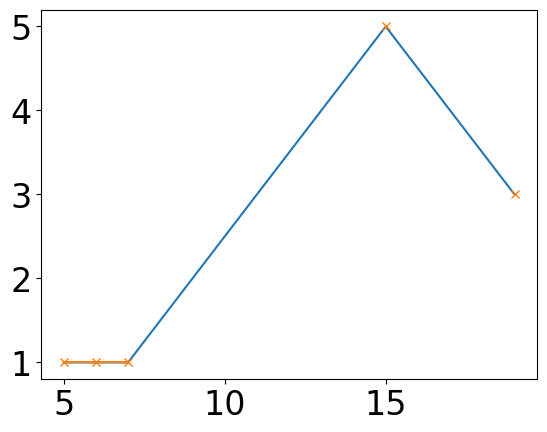

In [6]:
def standard_LI(data):
    out_data = data.copy()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            prev_avail_pix = -1
            next_avail_pix = -1
            for k in range(data.shape[2]):
                if np.isnan(data[i,j,k]):
                    if (prev_avail_pix>-1) and (next_avail_pix>-1):
                        delta_x = next_avail_pix - prev_avail_pix
                        delta_y = data[i,j,next_avail_pix] - data[i,j,prev_avail_pix]
                        m = delta_y / float(delta_x)
                        out_data[i,j,k] = data[i,j,prev_avail_pix] + m * float(k - prev_avail_pix)
                else:
                    prev_avail_pix = k
                    for n in range(k+1, data.shape[2]):
                        if ~np.isnan(data[i,j,n]):
                            next_avail_pix = n
                            break
    return out_data

n = 20
t = range(n)
test_data = np.zeros((1,1,n))
test_data[0,0,0:5] = np.nan
test_data[0,0,5:8] = 1.
test_data[0,0,8:15] = np.nan
test_data[0,0,15:16] = 5.
test_data[0,0,16:19] = np.nan
test_data[0,0,19] = 3.
test_SLI = standard_LI(test_data)
plt.plot(t, test_SLI[0,0,:])
plt.plot(t, test_data[0,0,:],'-x')
plt.show()

In [7]:
def retrun_comparison_points(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    masked_out_vec = []
    for out_i in out_vec:
        masked_out_vec.append(out_i[mask_cmp])
    masked_data_ref = data_ref[mask_cmp]
    return masked_out_vec, masked_data_ref

In [8]:
def compute_RMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        rerr.append(RMSE)
    return rerr

In [9]:
def compute_CVRMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        mean_ref = np.abs(np.mean(np.array(data_ref[mask_cmp], dtype=np.double)))
        CVRMSE = RMSE / mean_ref
        rerr.append(CVRMSE)
    return rerr

In [10]:
def compute_RMSE_std(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        std_ref = np.std(np.array(data_ref[mask_cmp], dtype=np.double))
        RMSE_std = RMSE / std_ref
        rerr.append(RMSE_std)
    return rerr

In [11]:
def compute_R_sq(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        corr_matrix = np.corrcoef(data_ref[mask_cmp], out_i[mask_cmp])
        corr = corr_matrix[0,1]
        R_sq = corr**2
        rerr.append(R_sq)
    return rerr

In [12]:
def compute_CCC(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        x = data_ref[mask_cmp]
        y = out_i[mask_cmp]

        mean_x = np.mean(x)
        mean_y = np.mean(y)
        var_x = np.var(x)
        var_y = np.var(y)
        covariance = np.mean((x - mean_x) * (y - mean_y))

        ccc = (2 * covariance) / (var_x + var_y + (mean_x - mean_y) ** 2)
        rerr.append(ccc)
    return rerr

In [13]:
def compute_NDVI(data_ref_nir, data_ref_red):
    data_ref = (data_ref_nir - data_ref_red) / (data_ref_nir + data_ref_red)
    data_ref[data_ref == np.infty] = np.nan
    data_ref[data_ref == -np.infty] = np.nan
    data_ref[data_ref < -1.] = -1.
    data_ref[data_ref > 1.] = 1.
    return data_ref

In [14]:
merged_agg_data_1c = np.load('merged_agg_data_1c.npy')
merged_agg_data_ge2c = np.load('merged_agg_data_ge2c.npy')
merged_agg_data_0c = np.load('merged_agg_data_0c.npy')

In [15]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # Blue to green to yellow to red
n_bins = [100, 100, 100, 100]  # Number of bins for each color
cmap_name = 'custom_colormap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=np.max(n_bins))

## Scatter reconstructed vs original NDVI

In [16]:
%%time
nan_fraction_vec = np.linspace(0,1,13)[1:-2]
n_bands = 7
use_future = 0
w_l = 2
p_o = 2
coef = savgol_coeffs(w_l*2+1, p_o, use='dot')
n_t_tot_1c = merged_agg_data_1c.shape[0]
n_t_tot_0c = merged_agg_data_0c.shape[0]
n_t_tot_ge2c = merged_agg_data_ge2c.shape[0]
n_t_1c = int(n_t_tot_1c/n_bands)
n_t_0c = int(n_t_tot_0c/n_bands)
n_t_ge2c = int(n_t_tot_ge2c/n_bands)
n_s = merged_agg_data_1c.shape[1]


# Create reference and gappy data

data_tmp = np.concatenate((merged_agg_data_1c[2*n_t_1c:(2+1)*n_t_1c,:], \
                           merged_agg_data_ge2c[2*n_t_ge2c:(2+1)*n_t_ge2c,:], \
                           merged_agg_data_0c[2*n_t_0c:(2+1)*n_t_0c,:]), axis=0)
n_t = data_tmp.shape[0]      
data_ref_red = np.zeros((1, n_t, n_s))
data_ref_red[0,:,:] = data_tmp.copy()
data_tmp = np.concatenate((merged_agg_data_1c[3*n_t_1c:(3+1)*n_t_1c,:], \
                           merged_agg_data_ge2c[3*n_t_ge2c:(3+1)*n_t_ge2c,:], \
                           merged_agg_data_0c[3*n_t_0c:(3+1)*n_t_0c,:]), axis=0)
n_t = data_tmp.shape[0]      
data_ref_nir = np.zeros((1, n_t, n_s))
data_ref_nir[0,:,:] = data_tmp.copy()

data_ref = compute_NDVI(data_ref_nir, data_ref_red)
nan_fraction = nan_fraction_vec[0]                
data_red = add_nan_elements(data_ref_red, nan_fraction)
data_nir = data_ref_nir.copy()
data_nir[np.isnan(data_red)] = np.nan

# Reconstruct the images with different methods for NDVI (reconstruct first)

out_SLI_red = standard_LI(data_red)
out_SLI_nir = standard_LI(data_nir)
out_SLI = compute_NDVI(out_SLI_nir, out_SLI_red)

wv_f_LI = 1-np.arange(1,n_s)/n_s
wv_p_LI = wv_f_LI.copy()[::-1]
TsirfTransformer_LI = process.TsirfTransformer(wv_0=1, wv_f=wv_f_LI, wv_p=wv_p_LI, backend="dense", use_mask=True, return_den=True)
out_LI_red, _ = TsirfTransformer_LI._run(data_red)
out_LI_nir, _ = TsirfTransformer_LI._run(data_nir)
out_LI = compute_NDVI(out_LI_nir, out_LI_red)

wv_p_MR = get_SWA_weights(130, 0, 6, n_s)[1:][::-1]
wv_f_MR = get_SWA_weights(130, 0, 6, n_s)[1:]*use_future
TsirfTransformer_MR = process.TsirfTransformer(wv_0=1, wv_f=wv_f_MR, wv_p=wv_p_MR, backend="dense", use_mask=True, return_den=True)
out_MR_red, _ = TsirfTransformer_MR._run(data_red)
out_MR_nir, _ = TsirfTransformer_MR._run(data_nir)
out_MR = compute_NDVI(out_MR_nir, out_MR_red)

wv_0_SG = coef[w_l]
wv_f_SG = coef[w_l+1:]
wv_p_SG = coef[0:w_l]
TsirfTransformer_SG = process.TsirfTransformer(wv_0=wv_0_SG, wv_f=wv_f_SG, wv_p=wv_p_SG, backend="sparse", use_mask=False)
out_SG_red = TsirfTransformer_SG._run(out_MR_red)
out_SG_nir = TsirfTransformer_SG._run(out_MR_nir)
out_SG = compute_NDVI(out_SG_nir, out_SG_red)

wv_p_prod = get_SWA_weights(46, 45, 6, n_s)[1:][::-1]
wv_f_prod = get_SWA_weights(46, 45, 6, n_s)[1:]*use_future
TsirfTransformer_prod = process.TsirfTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True, return_den=True)
out_prod_red, _ = TsirfTransformer_prod._run(data_red)
out_prod_nir, _ = TsirfTransformer_prod._run(data_nir)
out_prod = compute_NDVI(out_prod_nir, out_prod_red)

wv_0_SG2 = coef[w_l]
wv_f_SG2 = coef[w_l+1:]
wv_p_SG2 = coef[0:w_l]
TsirfTransformer_SG2 = process.TsirfTransformer(wv_0=wv_0_SG2, wv_f=wv_f_SG2, wv_p=wv_p_SG2, backend="sparse", use_mask=False)
out_SG2_red = TsirfTransformer_SG2._run(out_prod_red)
out_SG2_nir = TsirfTransformer_SG2._run(out_prod_nir)
out_SG2 = compute_NDVI(out_SG2_nir, out_SG2_red)

out_vec = (out_LI, out_SG, out_SG2, out_prod, out_SLI)
masked_out_vec, masked_data_ref = retrun_comparison_points(out_vec, data_red, data_ref)


/tmp/ipykernel_120/2683941170.py:2: RuntimeWarning: invalid value encountered in divide
  data_ref = (data_ref_nir - data_ref_red) / (data_ref_nir + data_ref_red)
/tmp/ipykernel_120/1914262335.py:12: RuntimeWarning: invalid value encountered in scalar divide
  m = delta_y / float(delta_x)


CPU times: user 1min 37s, sys: 5.35 s, total: 1min 42s
Wall time: 1min 1s


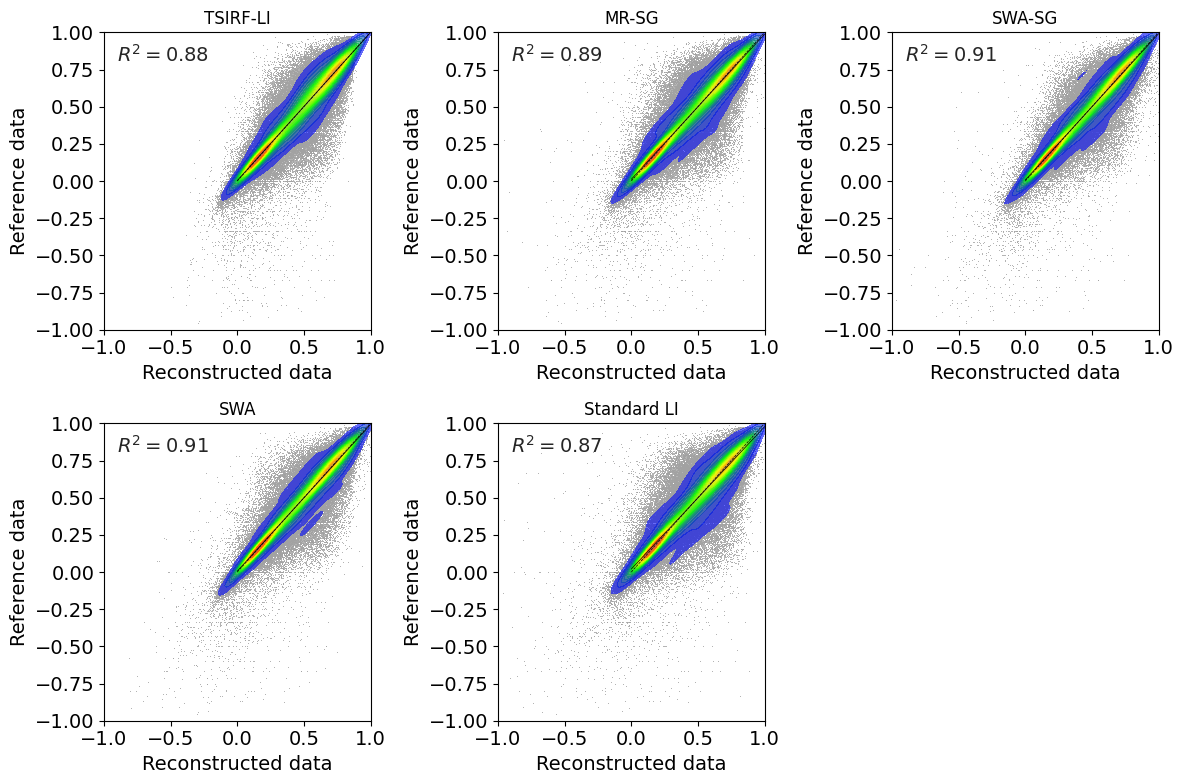

In [17]:
methods_name = ['TSIRF-LI', 'MR-SG', 'SWA-SG', 'SWA', 'Standard LI']

font_size = 14
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)    
plt.rc('ytick', labelsize=font_size)   
plt.rc('legend', fontsize=font_size) 
plt.rc('figure', titlesize=font_size) 

# Create a figure and axis objects
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axs.flat):
    if i < len(methods_name):
        down_sampling = 300
        original_data = masked_data_ref
        reconstructed_data = masked_out_vec[i]
        original_data_ds = masked_data_ref[0::down_sampling]
        reconstructed_data_ds = masked_out_vec[i][0::down_sampling]

        corr_matrix = np.corrcoef(original_data, reconstructed_data)
        corr = corr_matrix[0,1]
        R_sq = corr**2
        lm = LinearRegression()
        lm.fit(reconstructed_data.reshape(-1, 1), original_data)

        diag = np.linspace(0,1,1000)
        ax.plot(diag, lm.intercept_+ diag * lm.coef_[0], color='black',linewidth=0.5)
        ax.plot(diag, diag,'--',  color='black',linewidth=0.5)

        df = pd.DataFrame({'Reference data': original_data, 'Reconstructed data': reconstructed_data})
        df_ds = pd.DataFrame({'Reference data': original_data_ds, 'Reconstructed data': reconstructed_data_ds})
        sns.scatterplot(
            data=df,
            x="Reconstructed data",
            y="Reference data",
            color="gray",
            ax=ax,
            s=0.5,
        )    
        sns.set(style="white", color_codes=True)
        sns.kdeplot(
            data=df_ds,
            x="Reconstructed data",
            y="Reference data",
            cmap=cm, 
            fill=True, 
            levels=20,
            alpha=0.6,
            cut=2,
            ax=ax,
        )
        ax.text(-0.9, 0.80, f'$R^2={R_sq:.2f}$', fontsize=font_size)
        ax.set_ylim((-1, 1))
        ax.set_xlim((-1, 1))
        ax.set_title(methods_name[i], y=1.0,)
    else:
        ax.axis('off')  # Turn off empty subplot


plt.tight_layout()
plt.show()

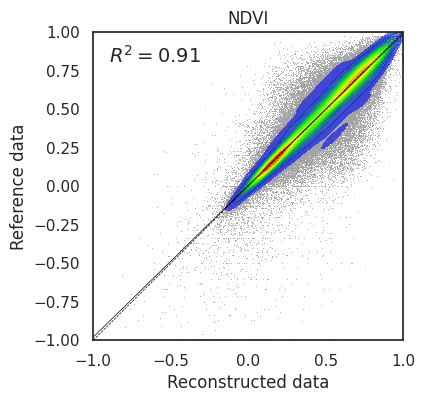

In [18]:
methods_name = ['TSIRF LI', 'MR-SG', 'SWA-SG', 'SWA', 'Standard LI']

i = 3
down_sampling = 300
original_data = masked_data_ref
reconstructed_data = masked_out_vec[i]
original_data_ds = masked_data_ref[0::down_sampling]
reconstructed_data_ds = masked_out_vec[i][0::down_sampling]

corr_matrix = np.corrcoef(original_data, reconstructed_data)
corr = corr_matrix[0,1]
R_sq = corr**2
lm = LinearRegression()
lm.fit(reconstructed_data.reshape(-1, 1), original_data)
fig = plt.figure(figsize=(4,4))
plt.rcParams.update({'font.size': 16})
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
diag = np.linspace(-1,1,2000)
ax.plot(diag, lm.intercept_+ diag * lm.coef_[0], color='black',linewidth=0.5)
ax.plot(diag, diag,'--',  color='black',linewidth=0.5)

df = pd.DataFrame({'Reference data': original_data, 'Reconstructed data': reconstructed_data})
df_ds = pd.DataFrame({'Reference data': original_data_ds, 'Reconstructed data': reconstructed_data_ds})
sns.scatterplot(
    data=df,
    x="Reconstructed data",
    y="Reference data",
    color="gray",
    ax=ax,
    s=0.5,
)    
sns.set(style="white", color_codes=True)
sns.kdeplot(
    data=df_ds,
    x="Reconstructed data",
    y="Reference data",
    cmap=cm, 
    fill=True, 
    levels=20,
    alpha=0.6,
    cut=2,
    ax=ax,
)
plt.text(-0.9, 0.80,  f'$R^2={R_sq:.2f}$', fontsize=font_size)
plt.ylim((-1, 1))
plt.xlim((-1, 1))
plt.title(f'NDVI', y=1.0,)

plt.savefig('scatter_methods.png', dpi=600, bbox_inches="tight")
plt.savefig('scatter_methods.pdf', format='pdf', bbox_inches="tight")
plt.show()


## Scatter error for different bands

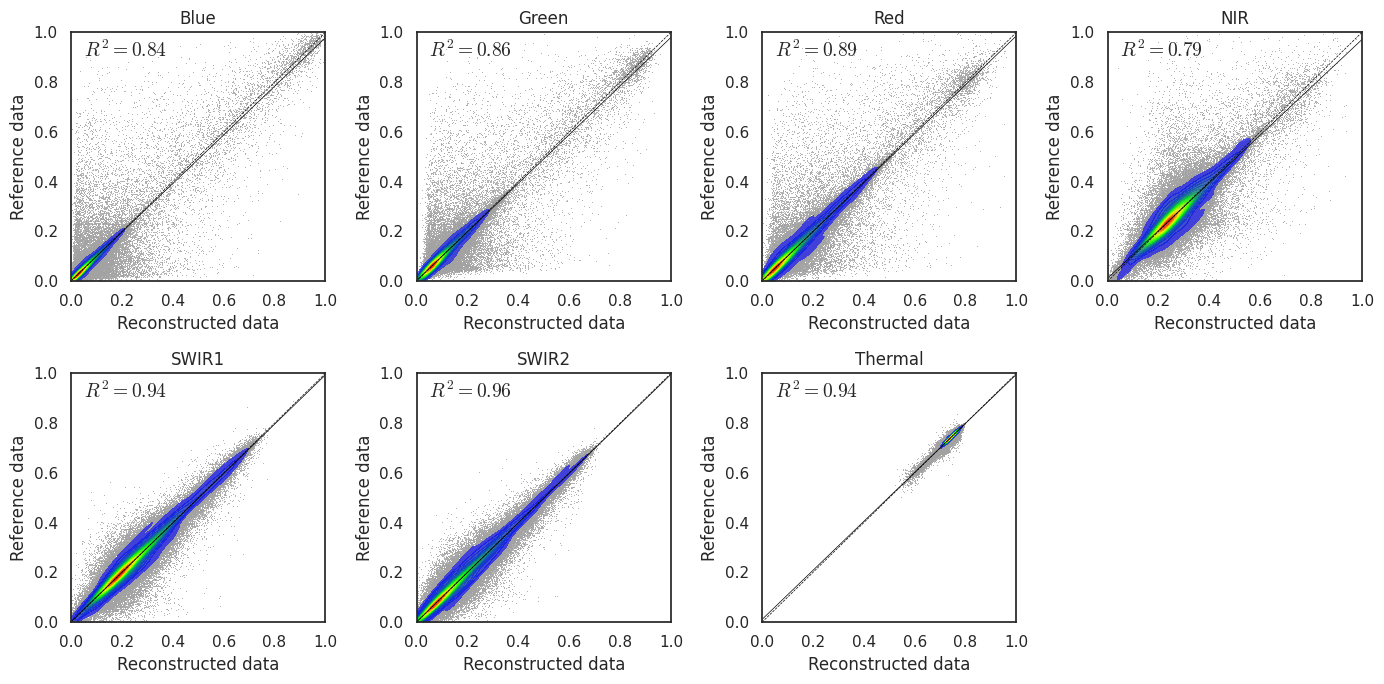

CPU times: user 1min 59s, sys: 9.55 s, total: 2min 8s
Wall time: 26.4 s


In [101]:
%%time
nan_fraction_vec = np.linspace(0,1,13)[1:-2]
n_bands = 7

use_future = 0
w_l = 2
p_o = 2
coef = savgol_coeffs(w_l*2+1, p_o, use='dot')
n_t_tot_1c = merged_agg_data_1c.shape[0]
n_t_tot_0c = merged_agg_data_0c.shape[0]
n_t_tot_ge2c = merged_agg_data_ge2c.shape[0]
n_t_1c = int(n_t_tot_1c/n_bands)
n_t_0c = int(n_t_tot_0c/n_bands)
n_t_ge2c = int(n_t_tot_ge2c/n_bands)
n_s = merged_agg_data_1c.shape[1]

out_vec = ()
bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']

# Create a figure and axis objects
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

for i, ax in enumerate(axs.flat):
    if i < len(bands):
        k = i  # index for bands
        data_tmp = np.concatenate((merged_agg_data_1c[k*n_t_1c:(k+1)*n_t_1c,:], \
                                   merged_agg_data_ge2c[k*n_t_ge2c:(k+1)*n_t_ge2c,:], \
                                   merged_agg_data_0c[k*n_t_0c:(k+1)*n_t_0c,:]), axis=0)
        n_t = data_tmp.shape[0]      
        data_ref = np.zeros((1, n_t, n_s))
        data_ref[0,:,:] = data_tmp.copy()

        nan_fraction = nan_fraction_vec[0]
        data = add_nan_elements(data_ref, nan_fraction)

        wv_p_prod = get_SWA_weights(46, 45, 6, n_s)[1:][::-1]
        wv_f_prod = get_SWA_weights(46, 45, 6, n_s)[1:]*use_future
        TsirfTransformer_prod = process.TsirfTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True, return_den=True)
        out_prod, mask_prod = TsirfTransformer_prod._run(data)

        mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
        mask_cmp = mask_cmp & ~np.isnan(out_prod)
        masked_data_ref = data_ref[mask_cmp]
        masked_out_prod = out_prod[mask_cmp]

        down_sampling = 300
        original_data = masked_data_ref
        reconstructed_data = masked_out_prod
        original_data_ds = masked_data_ref[0::down_sampling]
        reconstructed_data_ds = masked_out_prod[0::down_sampling]

        corr_matrix = np.corrcoef(original_data, reconstructed_data)
        corr = corr_matrix[0,1]
        R_sq = corr**2
        lm = LinearRegression()
        lm.fit(reconstructed_data.reshape(-1, 1), original_data)

        diag = np.linspace(0,1,1000)
        ax.plot(diag, lm.intercept_+ diag * lm.coef_[0], color='black',linewidth=0.5)
        ax.plot(diag, diag,'--',  color='black',linewidth=0.5)

        df = pd.DataFrame({'Reference data': original_data, 'Reconstructed data': reconstructed_data})
        df_ds = pd.DataFrame({'Reference data': original_data_ds, 'Reconstructed data': reconstructed_data_ds})
        sns.scatterplot(
            data=df,
            x="Reconstructed data",
            y="Reference data",
            color="gray",
            ax=ax,
            s=0.5,
        )    
        sns.set(style="white", color_codes=True)
        sns.kdeplot(
            data=df_ds,
            x="Reconstructed data",
            y="Reference data",
            cmap=cm, 
            fill=True, 
            levels=20,
            alpha=0.6,
            cut=2,
            ax=ax,
        )

        ax.text(0.05, 0.9, f'$R^2={R_sq:.2f}$', fontsize=font_size)
        ax.set_ylim((0, 1))
        ax.set_xlim((0, 1))
        ax.set_title(bands[k], y=1.0,)
    else:
        ax.axis('off')  # Turn off empty subplot

# Adjust layout
plt.tight_layout()

# Save and show the plot
plt.savefig('scatter_bands.png', dpi=400, bbox_inches="tight")
plt.show()


# Compute RMSE for different methods

In [19]:
%%time
nan_fraction_vec = np.linspace(0,1,13)[1:-2]
n_methods = 5
n_bands = 7
n_iter = 3
RMSE_mat = np.zeros((len(nan_fraction_vec), n_methods, n_bands+2, n_iter), np.double)
tot_nan_fracs = np.zeros((len(nan_fraction_vec), n_bands+2, n_iter), np.double)

use_future = 0
w_l = 2
p_o = 2
coef = savgol_coeffs(w_l*2+1, p_o, use='dot')
n_t_tot_1c = merged_agg_data_1c.shape[0]
n_t_tot_0c = merged_agg_data_0c.shape[0]
n_t_tot_ge2c = merged_agg_data_ge2c.shape[0]
n_t_1c = int(n_t_tot_1c/n_bands)
n_t_0c = int(n_t_tot_0c/n_bands)
n_t_ge2c = int(n_t_tot_ge2c/n_bands)
n_s = merged_agg_data_1c.shape[1]
for it in range(n_iter):
    for k in range(n_bands+2):
    # for k in [n_bands,]:
        if k >= n_bands:
            data_tmp = np.concatenate((merged_agg_data_1c[2*n_t_1c:(2+1)*n_t_1c,:], \
                                       merged_agg_data_ge2c[2*n_t_ge2c:(2+1)*n_t_ge2c,:], \
                                       merged_agg_data_0c[2*n_t_0c:(2+1)*n_t_0c,:]), axis=0)
            n_t = data_tmp.shape[0]      
            data_ref_red = np.zeros((1, n_t, n_s))
            data_ref_red[0,:,:] = data_tmp.copy()
            data_tmp = np.concatenate((merged_agg_data_1c[3*n_t_1c:(3+1)*n_t_1c,:], \
                                       merged_agg_data_ge2c[3*n_t_ge2c:(3+1)*n_t_ge2c,:], \
                                       merged_agg_data_0c[3*n_t_0c:(3+1)*n_t_0c,:]), axis=0)
            n_t = data_tmp.shape[0]      
            data_ref_nir = np.zeros((1, n_t, n_s))
            data_ref_nir[0,:,:] = data_tmp.copy()
            
            data_ref = compute_NDVI(data_ref_nir, data_ref_red)
            
            
        else:
            data_tmp = np.concatenate((merged_agg_data_1c[k*n_t_1c:(k+1)*n_t_1c,:], \
                                       merged_agg_data_ge2c[k*n_t_ge2c:(k+1)*n_t_ge2c,:], \
                                       merged_agg_data_0c[k*n_t_0c:(k+1)*n_t_0c,:]), axis=0)
            n_t = data_tmp.shape[0]      
            data_ref = np.zeros((1, n_t, n_s))
            data_ref[0,:,:] = data_tmp.copy()
            

        for i, nan_fraction in enumerate(nan_fraction_vec):
            
            if k == n_bands + 1:
                
                data_red = add_nan_elements(data_ref_red, nan_fraction)
                data_nir = data_ref_nir.copy()
                data_nir[np.isnan(data_red)] = np.nan
                tot_nan_fracs[i,k,it] = np.sum(np.isnan(data_red).astype(int))/data_red.size

                out_SLI_red = standard_LI(data_red)
                out_SLI_nir = standard_LI(data_nir)
                out_SLI = compute_NDVI(out_SLI_nir, out_SLI_red)
                
                wv_f_LI = 1-np.arange(1,n_s)/n_s
                wv_p_LI = wv_f_LI.copy()[::-1]
                TsirfTransformer_LI = process.TsirfTransformer(wv_0=1, wv_f=wv_f_LI, wv_p=wv_p_LI, backend="dense", use_mask=True, return_den=True)
                out_LI_red, _ = TsirfTransformer_LI._run(data_red)
                out_LI_nir, _ = TsirfTransformer_LI._run(data_nir)
                out_LI = compute_NDVI(out_LI_nir, out_LI_red)

                wv_p_MR = get_SWA_weights(130, 0, 6, n_s)[1:][::-1]
                wv_f_MR = get_SWA_weights(130, 0, 6, n_s)[1:]*use_future
                TsirfTransformer_MR = process.TsirfTransformer(wv_0=1, wv_f=wv_f_MR, wv_p=wv_p_MR, backend="dense", use_mask=True, return_den=True)
                out_MR_red, _ = TsirfTransformer_MR._run(data_red)
                out_MR_nir, _ = TsirfTransformer_MR._run(data_nir)
                out_MR = compute_NDVI(out_MR_nir, out_MR_red)
                

                wv_0_SG = coef[w_l]
                wv_f_SG = coef[w_l+1:]
                wv_p_SG = coef[0:w_l]
                TsirfTransformer_SG = process.TsirfTransformer(wv_0=wv_0_SG, wv_f=wv_f_SG, wv_p=wv_p_SG, backend="sparse", use_mask=False)
                out_SG_red = TsirfTransformer_SG._run(out_MR_red)
                out_SG_nir = TsirfTransformer_SG._run(out_MR_nir)
                out_SG = compute_NDVI(out_SG_nir, out_SG_red)

                wv_p_prod = get_SWA_weights(46, 45, 6, n_s)[1:][::-1]
                wv_f_prod = get_SWA_weights(46, 45, 6, n_s)[1:]*use_future
                TsirfTransformer_prod = process.TsirfTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True, return_den=True)
                out_prod_red, _ = TsirfTransformer_prod._run(data_red)
                out_prod_nir, _ = TsirfTransformer_prod._run(data_nir)
                out_prod = compute_NDVI(out_prod_nir, out_prod_red)

                wv_0_SG2 = coef[w_l]
                wv_f_SG2 = coef[w_l+1:]
                wv_p_SG2 = coef[0:w_l]
                TsirfTransformer_SG2 = process.TsirfTransformer(wv_0=wv_0_SG2, wv_f=wv_f_SG2, wv_p=wv_p_SG2, backend="sparse", use_mask=False)
                out_SG2_red = TsirfTransformer_SG2._run(out_prod_red)
                out_SG2_nir = TsirfTransformer_SG2._run(out_prod_nir)
                out_SG2 = compute_NDVI(out_SG2_nir, out_SG2_red)

                out_vec = (out_LI, out_SG, out_SG2, out_prod, out_SLI)
                RMSE_mat[i,:,k,it] = compute_RMSE(out_vec, data_red, data_ref)
                
                
            else:
            
                data = add_nan_elements(data_ref, nan_fraction)
                tot_nan_fracs[i,k,it] = np.sum(np.isnan(data).astype(int))/data.size
                
                out_SLI = standard_LI(data)

                wv_f_LI = 1-np.arange(1,n_s)/n_s
                wv_p_LI = wv_f_LI.copy()[::-1]
                TsirfTransformer_LI = process.TsirfTransformer(wv_0=1, wv_f=wv_f_LI, wv_p=wv_p_LI, backend="dense", use_mask=True, return_den=True)
                out_LI, mask_LI = TsirfTransformer_LI._run(data)

                wv_p_MR = get_SWA_weights(130, 0, 6, n_s)[1:][::-1]
                wv_f_MR = get_SWA_weights(130, 0, 6, n_s)[1:]*use_future
                TsirfTransformer_MR = process.TsirfTransformer(wv_0=1, wv_f=wv_f_MR, wv_p=wv_p_MR, backend="dense", use_mask=True, return_den=True)
                out_MR, mask_MR = TsirfTransformer_MR._run(data)

                wv_0_SG = coef[w_l]
                wv_f_SG = coef[w_l+1:]
                wv_p_SG = coef[0:w_l]
                TsirfTransformer_SG = process.TsirfTransformer(wv_0=wv_0_SG, wv_f=wv_f_SG, wv_p=wv_p_SG, backend="sparse", use_mask=False)
                out_SG = TsirfTransformer_SG._run(out_MR)

                wv_p_prod = get_SWA_weights(46, 45, 6, n_s)[1:][::-1]
                wv_f_prod = get_SWA_weights(46, 45, 6, n_s)[1:]*use_future
                TsirfTransformer_prod = process.TsirfTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True, return_den=True)
                out_prod, mask_prod = TsirfTransformer_prod._run(data)

                wv_0_SG2 = coef[w_l]
                wv_f_SG2 = coef[w_l+1:]
                wv_p_SG2 = coef[0:w_l]
                TsirfTransformer_SG2 = process.TsirfTransformer(wv_0=wv_0_SG2, wv_f=wv_f_SG2, wv_p=wv_p_SG2, backend="sparse", use_mask=False)
                out_SG2 = TsirfTransformer_SG2._run(out_prod)

                out_vec = (out_LI, out_SG, out_SG2, out_prod, out_SLI)

                RMSE_mat[i,:,k,it] = compute_RMSE(out_vec, data, data_ref)
RMSE_mat = np.mean(RMSE_mat, -1)
tot_nan_fracs = np.mean(tot_nan_fracs, -1)
                
RMSE_mean = np.mean(RMSE_mat, -1)
RMSE_std = np.std(RMSE_mat, -1)

CPU times: user 4h 6min 40s, sys: 11min 5s, total: 4h 17min 46s
Wall time: 2h 36min 20s


In [20]:
print('LI, MR-SG, ARCO-SG, ARCO, SLI')
print('RMSE mean, 10% artificial gaps')
print(RMSE_mean[0,:])
print('RMSE std, 10% artificial gaps')
print(RMSE_std[0,:])

LI, MR-SG, ARCO-SG, ARCO, SLI
RMSE mean, 10% artificial gaps
[0.04311055 0.04289541 0.03751611 0.03812459 0.04530424]
RMSE std, 10% artificial gaps
[0.02536775 0.02504173 0.02170499 0.02175518 0.02723847]


In [21]:
np.save('RMSE_mat_1', RMSE_mat)
np.save('RMSE_mean_1', RMSE_mean)
np.save('RMSE_std_1', RMSE_std)
np.save('tot_nan_fracs_1', tot_nan_fracs)
np.save('data_tmp_1', data_tmp)

In [19]:
RMSE_mat = np.load('RMSE_mat_1.npy')
RMSE_mean = np.load('RMSE_mean_1.npy')
RMSE_std = np.load('RMSE_std_1.npy')
tot_nan_fracs = np.load('tot_nan_fracs_1.npy')
data_tmp = np.load('data_tmp_1.npy')

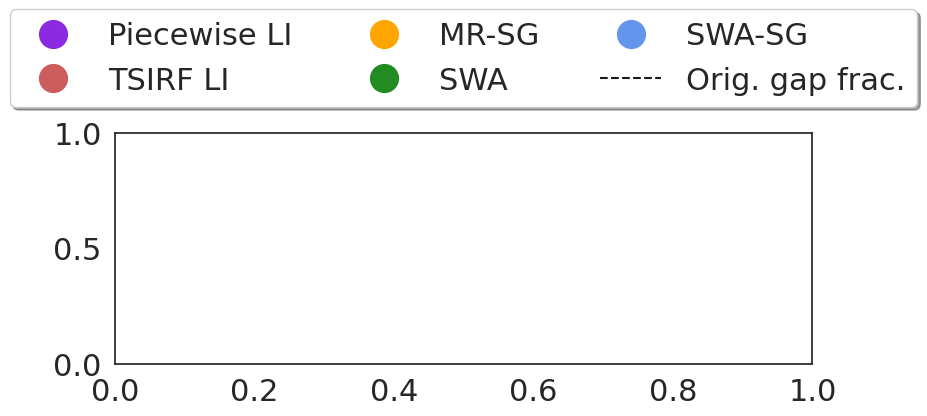

In [20]:
import matplotlib.lines as mlines
font_size = 22
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)    
plt.rc('ytick', labelsize=font_size)   
plt.rc('legend', fontsize=font_size) 
plt.rc('figure', titlesize=font_size)  
ms = 20
lw = 2.5
mw = 2
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(9,3))
SLI = mlines.Line2D([], [], color='blueviolet', marker='o', linestyle='None',
                          markersize=ms, label='Piecewise LI')
LI = mlines.Line2D([], [], color='indianred', marker='o', linestyle='None',
                          markersize=ms, label='TSIRF LI')
SWA_SG = mlines.Line2D([], [], color='cornflowerblue', marker='o', linestyle='None',
                          markersize=ms, label='SWA-SG')
SWA = mlines.Line2D([], [], color='forestgreen', marker='o', linestyle='None',
                          markersize=ms, label='SWA')
MR_SG = mlines.Line2D([], [], color='orange', marker='o', linestyle='None',
                          markersize=ms, label='MR-SG')

handles = [SLI, LI, MR_SG, SWA, SWA_SG]
handles.append(mlines.Line2D([], [], color='k', linestyle='--', label='Orig. gap frac.'))
    
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=3, fancybox=True, shadow=True)
plt.savefig(f'legend.svg', format='svg', bbox_inches="tight")

plt.show()

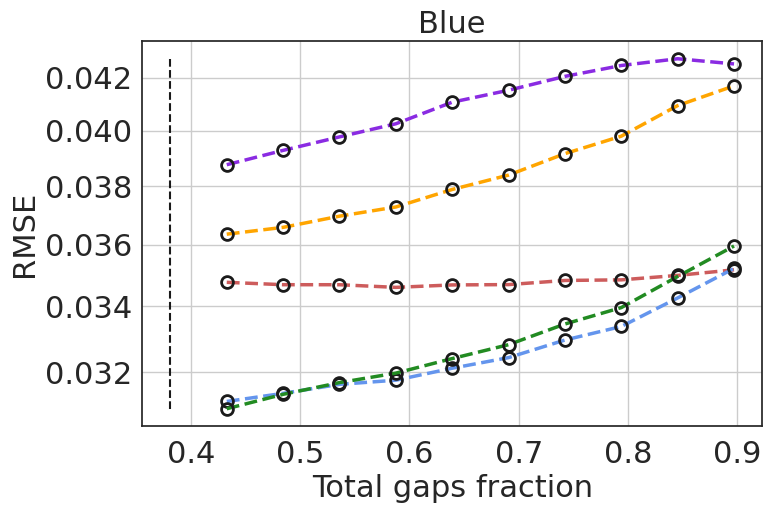

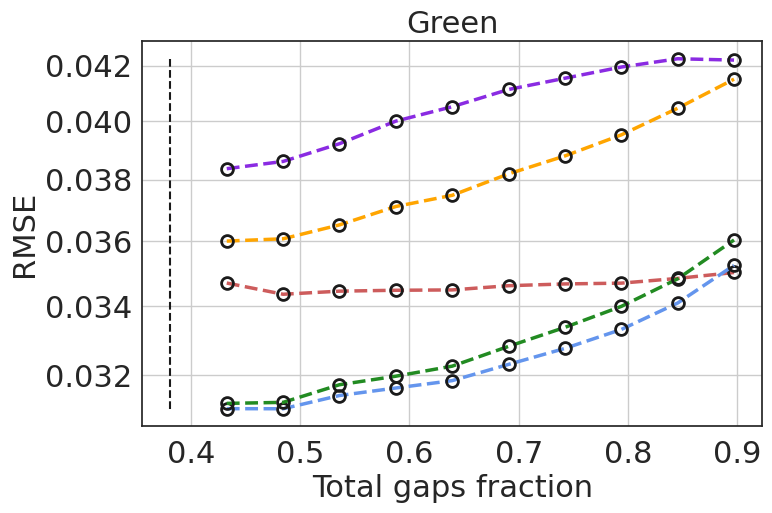

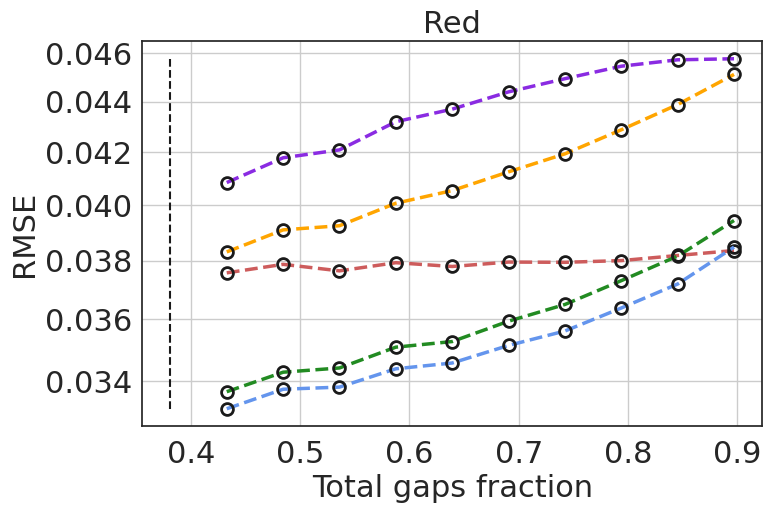

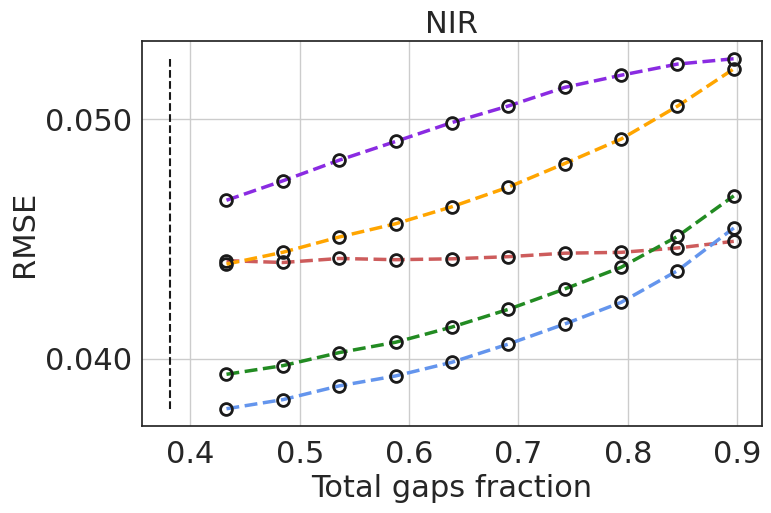

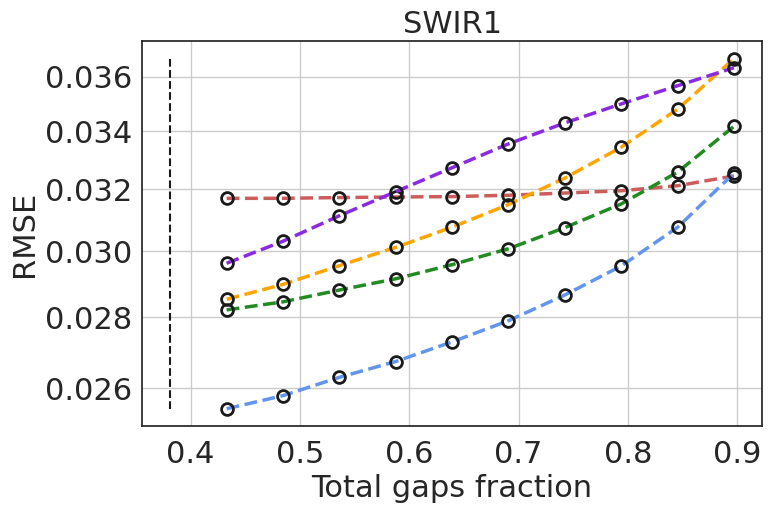

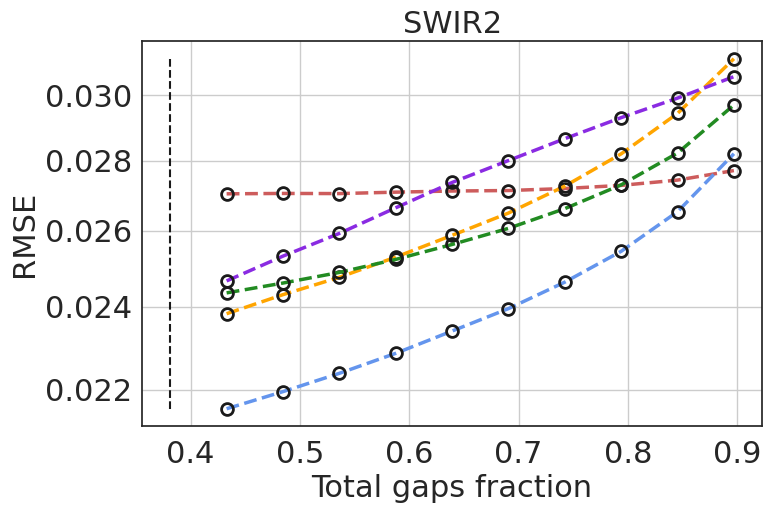

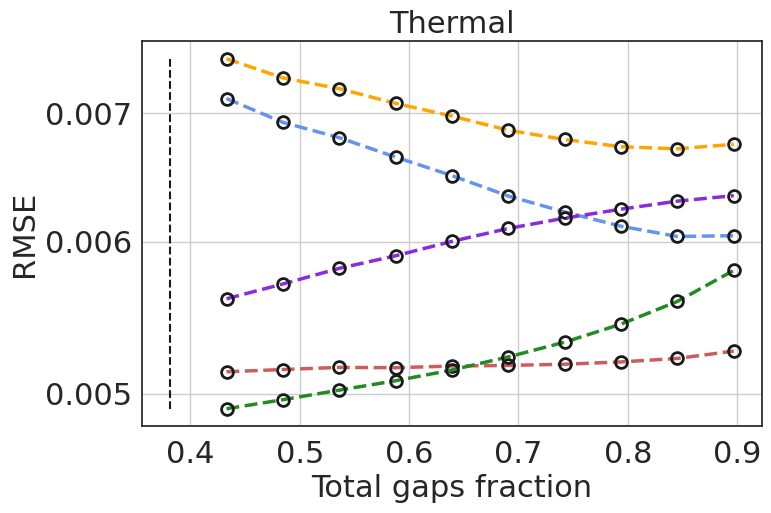

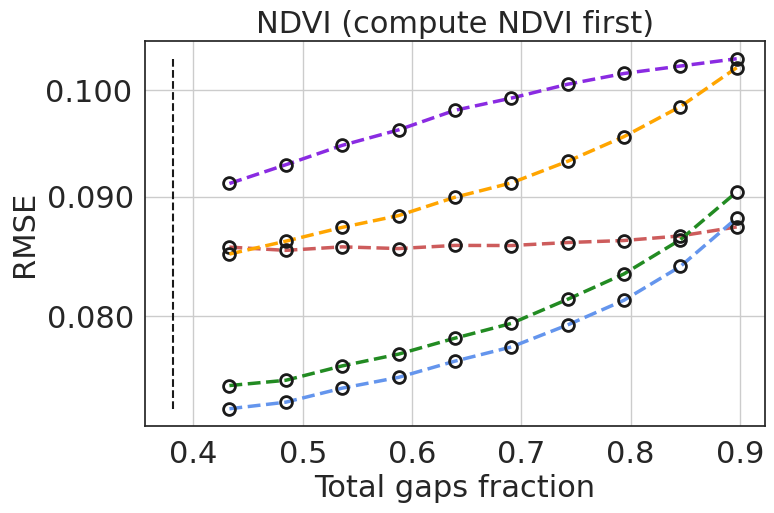

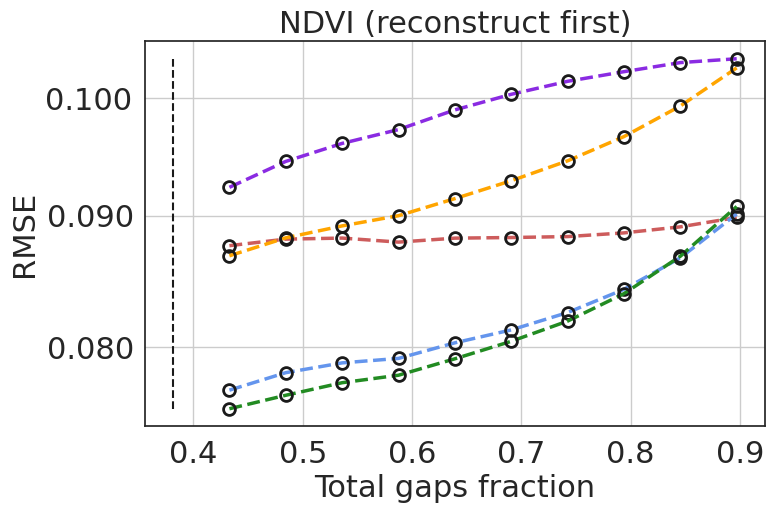

In [21]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter
import matplotlib
font_size = 22
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)    
plt.rc('ytick', labelsize=font_size)   
plt.rc('legend', fontsize=font_size) 
plt.rc('figure', titlesize=font_size)  
orig_gap_fraq = np.sum(np.isnan(data_tmp).astype(int))/data_tmp.size
bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal', 'NDVI (compute NDVI first)', 'NDVI (reconstruct first)']
color_list = ['navy', 'lawngreen', 'firebrick', 'darkorange', 'gold', 'darkslategray', 'darkviolet', 'white', 'white']
ymin = 0.01
ymax = 1
ms = 17
lw = 2.5
mw = 2
n_bands = 7
for k in range(n_bands+2):
# # For NIR, Red and NDVI use:
# for k in [2,3,7,8]:
    band = bands[k]
    plt.rcParams.update({'font.size': 24})
    plt.figure(figsize=(8,5))
    plt.semilogy(tot_nan_fracs[:,k], RMSE_mat[:,0,k], '.',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'indianred')
    plt.plot(tot_nan_fracs[:,k], RMSE_mat[:,1,k], '.',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'orange')
    plt.plot(tot_nan_fracs[:,k], RMSE_mat[:,2,k], '.',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'cornflowerblue')
    plt.plot(tot_nan_fracs[:,k], RMSE_mat[:,3,k], '.',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'forestgreen')
    plt.plot(tot_nan_fracs[:,k], RMSE_mat[:,4,k], '.',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, color = 'blueviolet')
    plt.vlines(orig_gap_fraq, np.min(RMSE_mat[:,:,k]), np.max(RMSE_mat[:,:,k]), colors='k', linestyles='--')
    plt.xlabel('Total gaps fraction')
    from matplotlib.ticker import ScalarFormatter
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(ScalarFormatter());
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
    plt.gca().yaxis.set_minor_formatter(plt.FormatStrFormatter('%.3f'));
    plt.ylabel('RMSE')
    plt.title(band, y=1.0,)
    plt.grid(True, which="both", ls="-")
    plt.savefig(f'RMSE_{band}.svg', format='svg', bbox_inches="tight")
    plt.show()


## Compare different error metrics per band

In [115]:
%%time
nan_fraction_vec = np.linspace(0,1,13)[1:-2]
n_methods = 5
n_bands = 7
n_iter = 3
RMSE = np.zeros((n_bands, n_iter), np.double)
CVRMSE = np.zeros((n_bands, n_iter), np.double)
RMSE_std = np.zeros((n_bands, n_iter), np.double)
R_sq = np.zeros((n_bands, n_iter), np.double)
CCC = np.zeros((n_bands, n_iter), np.double)
tot_nan_fracs = np.zeros((len(nan_fraction_vec), n_bands+2, n_iter), np.double)

use_future = 0
w_l = 2
p_o = 2
coef = savgol_coeffs(w_l*2+1, p_o, use='dot')
n_t_tot_1c = merged_agg_data_1c.shape[0]
n_t_tot_0c = merged_agg_data_0c.shape[0]
n_t_tot_ge2c = merged_agg_data_ge2c.shape[0]
n_t_1c = int(n_t_tot_1c/n_bands)
n_t_0c = int(n_t_tot_0c/n_bands)
n_t_ge2c = int(n_t_tot_ge2c/n_bands)
n_s = merged_agg_data_1c.shape[1]
nan_fraction = 0.1
for it in range(n_iter):
    for k in range(n_bands):
        data_tmp = np.concatenate((merged_agg_data_1c[k*n_t_1c:(k+1)*n_t_1c,:], \
                                   merged_agg_data_ge2c[k*n_t_ge2c:(k+1)*n_t_ge2c,:], \
                                   merged_agg_data_0c[k*n_t_0c:(k+1)*n_t_0c,:]), axis=0)
        n_t = data_tmp.shape[0]      
        data_ref = np.zeros((1, n_t, n_s))
        data_ref[0,:,:] = data_tmp.copy()
        data = add_nan_elements(data_ref, nan_fraction)
        wv_p_prod = get_SWA_weights(46, 45, 6, n_s)[1:][::-1]
        wv_f_prod = get_SWA_weights(46, 45, 6, n_s)[1:]*use_future
        TsirfTransformer_prod = process.TsirfTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True, return_den=True)
        out_prod, mask_prod = TsirfTransformer_prod._run(data)
        out_vec = (out_prod, )
        RMSE[k,it] = compute_RMSE(out_vec, data, data_ref)[0]
        CVRMSE[k,it] = compute_CVRMSE(out_vec, data, data_ref)[0]
        RMSE_std[k,it] = compute_RMSE_std(out_vec, data, data_ref)[0]
        R_sq[k,it] = compute_R_sq(out_vec, data, data_ref)[0]
        CCC[k,it] = compute_CCC(out_vec, data, data_ref)[0]
        
        
RMSE = np.mean(RMSE, -1)
CVRMSE = np.mean(CVRMSE, -1)
RMSE_std = np.mean(RMSE_std, -1)
R_sq = np.mean(R_sq, -1)
CCC = np.mean(CCC, -1)


CPU times: user 4min 10s, sys: 23 s, total: 4min 33s
Wall time: 35.6 s


In [116]:
print("RMSE")
print(RMSE)
print("CVRMSE")
print(CVRMSE)
print("RMSE_std")
print(RMSE_std)
print("R_sq")
print(R_sq)
print("CCC")
print(CCC)

RMSE
[0.03135759 0.03120168 0.03414227 0.03938327 0.02826056 0.02446134
 0.00494324]
CVRMSE
[0.55747213 0.3327127  0.31662629 0.15059417 0.11749079 0.15130693
 0.00666821]
RMSE_std
[0.39214574 0.37438766 0.33218234 0.45715364 0.24789373 0.20351372
 0.2461475 ]
R_sq
[0.84675199 0.86032657 0.889917   0.79248111 0.93861302 0.95861159
 0.93960855]
CCC
[0.91852192 0.92623079 0.9424747  0.88767823 0.96855032 0.97896313
 0.96919714]


# Stratified comparison

In [25]:
import pyreadr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
sys.path.insert(0, os.path.abspath('../../'))
from skmap.data import toy
from skmap.io import process
import importlib
import time
importlib.reload(process)
from tqdm.notebook import tqdm
from scipy.signal import savgol_coeffs

In [26]:
strata = gpd.read_file('extracted_points_wgs84.gpkg')['Stratum'].to_numpy()
u_strata = np.unique(strata)
u_strata = np.delete(u_strata, 1, 0)

In [27]:
def add_nan_elements(A, fraction_of_nan):
    B = np.copy(A)
    non_nan_indices = np.where(~np.isnan(A))
    total_non_nan_elements = len(non_nan_indices[0])
    nan_elements_count = int(total_non_nan_elements * fraction_of_nan)
    chosen_indices = np.random.choice(total_non_nan_elements, nan_elements_count, replace=False)
    nan_indices = (non_nan_indices[0][chosen_indices], non_nan_indices[1][chosen_indices], non_nan_indices[2][chosen_indices])
    B[nan_indices] = np.nan
    return B

In [28]:
def compute_CVRMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        mean_ref = np.mean(np.array(data_ref[mask_cmp], dtype=np.double))
        CVRMSE = RMSE / mean_ref
        rerr.append(CVRMSE)
    return rerr

In [29]:
def compute_RMSE(out_vec, data, data_ref):
    mask_cmp = np.isnan(data) & ~np.isnan(data_ref)
    for out_i in out_vec:
        mask_cmp = mask_cmp & ~np.isnan(out_i)

    rerr = []
    for out_i in out_vec:
        diff = np.array(data_ref[mask_cmp] - out_i[mask_cmp])
        RMSE = np.sqrt(np.mean((diff) ** 2))
        rerr.append(RMSE)
    return rerr

In [30]:
def get_SWA_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row

In [40]:
bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']

n_strata = len(u_strata)
RMSE_mat = np.zeros((7,n_strata))
tot_nan_fracs = np.zeros((n_strata,))

nan_fraction = 0.1
clear_mat = pyreadr.read_r('clear_agg.rds')[None].to_numpy()
for i, band in enumerate(bands):
    band_mat = pyreadr.read_r(f'{band}_agg.rds')[None].to_numpy()/250.
    print(f"Band {band}")
    print(f"Stratum: ", end="")
    for j, stratum in enumerate(u_strata):
        print(f"{stratum}, ", end="")
        if stratum == 1:
            agg_nogap_mask_1 = (clear_mat[strata==1,:] == 1)    
            data_tmp_1 = band_mat[strata==1,:]
            n_t = data_tmp_1.shape[0]
            n_s = data_tmp_1.shape[1]
            agg_nogap_mask_2 = (clear_mat[strata==2,:] == 1)    
            data_tmp_2 = band_mat[strata==2,:]
            agg_nogap_mask = np.zeros((n_t, n_s), bool)
            data_tmp = np.zeros((n_t, n_s), np.double)
            cut = int(n_t*0.97)
            agg_nogap_mask[0:cut,:] = agg_nogap_mask_1[0:cut,:]
            agg_nogap_mask[cut:,:] = agg_nogap_mask_2[0:n_t-cut,:]
            data_tmp[0:cut,:] = data_tmp_1[0:cut,:]
            data_tmp[cut:,:] = data_tmp_2[0:n_t-cut,:]
        else:
            agg_nogap_mask = (clear_mat[strata==stratum,:] == 1)    
            data_tmp = band_mat[strata==stratum,:]            
        data_tmp[~agg_nogap_mask] = np.nan
        n_t = data_tmp.shape[0]
        n_s = data_tmp.shape[1]
        data_ref = np.zeros((1, n_t, n_s))
        data_ref[0,:,:] = data_tmp.copy()
        data = add_nan_elements(data_ref, nan_fraction)
        tot_nan_fracs[j] = np.sum(np.isnan(data).astype(int))/data.size

        wv_p_prod = get_SWA_weights(46, 45, 6, n_s)[1:][::-1]
        wv_f_prod = get_SWA_weights(46, 45, 6, n_s)[1:]*0.0
        TsirfTransformer_prod = process.TsirfTransformer(wv_0=1, wv_f=wv_f_prod, wv_p=wv_p_prod, backend="dense", use_mask=True)
        out_prod = TsirfTransformer_prod._run(data)
        
        RMSE_mat[i,j] = compute_RMSE((out_prod,), data, data_ref)[0]
    print(f" ")

    
    


Band blue
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band green
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band red
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band nir
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band swir1
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band swir2
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  
Band thermal
Stratum: 1, 10, 20, 30, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150, 160, 180, 190, 200, 220,  


## Legend of ESA-CCI at https://maps.elie.ucl.ac.be/CCI/viewer/download/CCI-LC_Maps_Legend.pdf

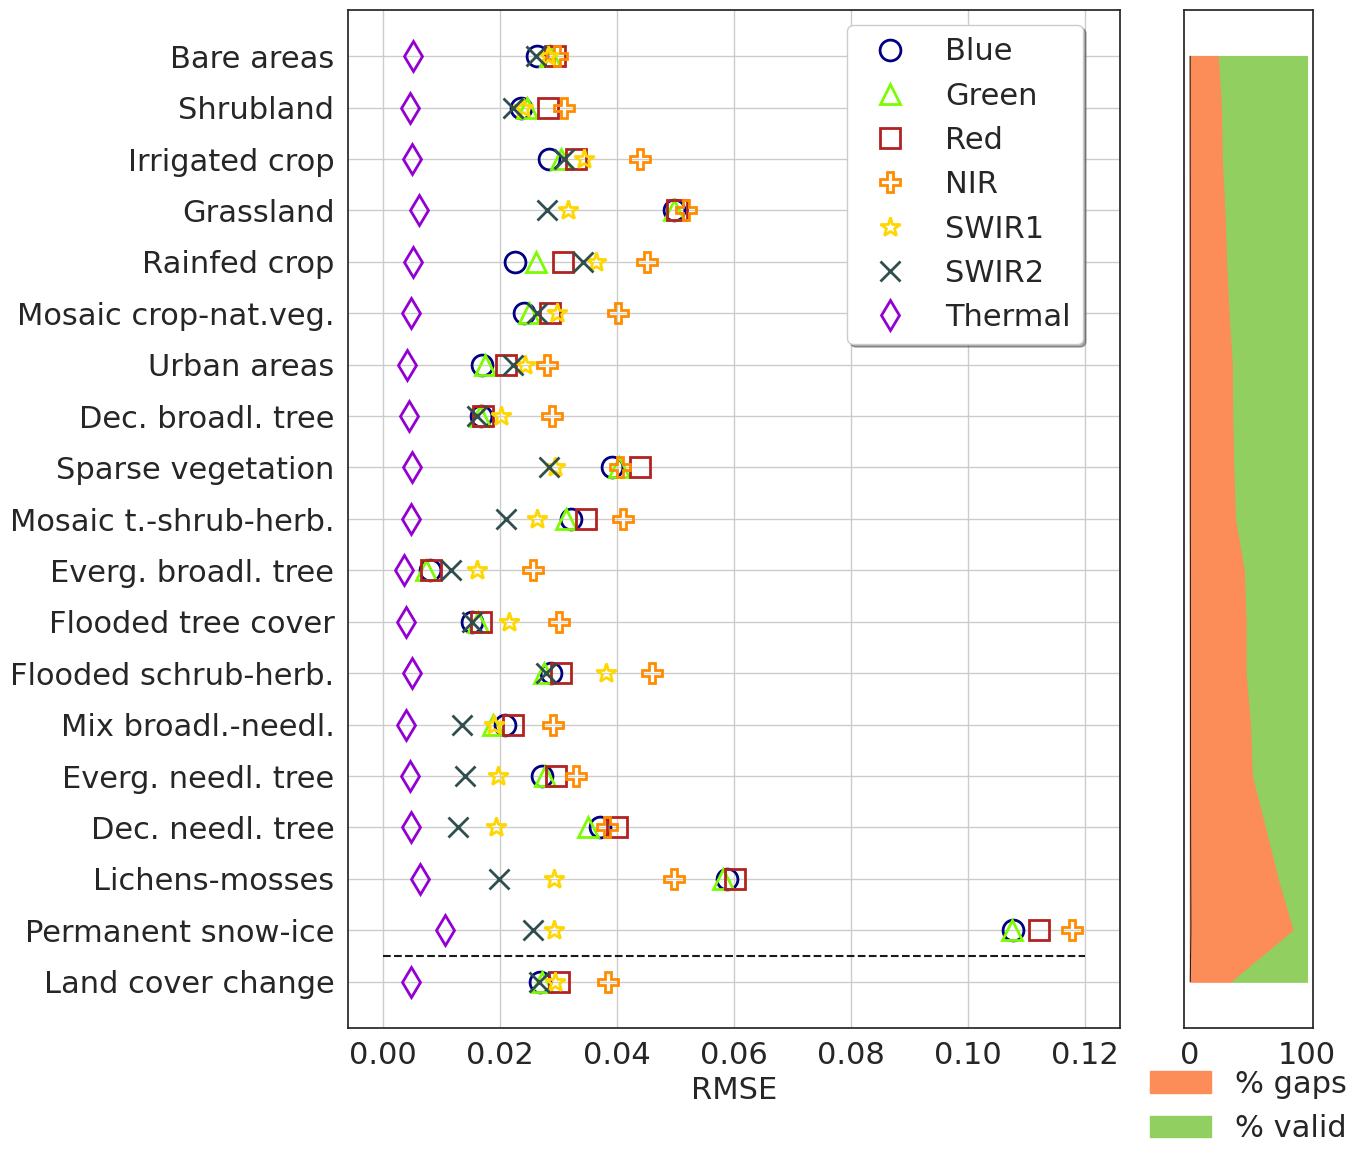

In [60]:
import matplotlib.lines as mlines
font_size = 22
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)    
plt.rc('ytick', labelsize=font_size)   
plt.rc('legend', fontsize=font_size) 
plt.rc('figure', titlesize=font_size)  
fig = plt.figure(figsize=(14,12))
grid = plt.GridSpec(1, 2, width_ratios=[6, 1])
ax1 = plt.subplot(grid[0])
ax2 = plt.subplot(grid[1])
order = np.argsort(tot_nan_fracs)[::-1]
range_arr = np.arange(order.size)  
tmp = order[np.where(order==0)[0][0]]
order[range_arr != 0 ] = order[range_arr != np.where(order==0)[0][0]]
order[0] = tmp
ms = 15
mw = 2
bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Thermal']
marker_list = ['o', '^', 's', 'P', '*', 'x', 'd']
color_list = ['navy', 'lawngreen', 'firebrick', 'darkorange', 'gold', 'darkslategray', 'darkviolet']
# ticks = ['1','2','10','20','30','50','60','70','80','90','100','120','130','140','150','160','180','190','200','220']
ticks_orig = ['Land cover change','Rainfed crop','Irrigated crop','Mosaic crop-nat.veg.','Everg. broadl. tree','Dec. broadl. tree','Everg. needl. tree','Dec. needl. tree', \
         'Mix broadl.-needl.','Mosaic t.-shrub-herb.','Shrubland','Grassland','Lichens-mosses','Sparse vegetation','Flooded tree cover','Flooded schrub-herb.','Urban areas','Bare areas','Permanent snow-ice']
handles = []
ticks = []

for i, band in enumerate(bands):
    handles.append(mlines.Line2D([], [], color=color_list[i], marker=marker_list[i], linestyle='None', markeredgewidth=mw, 
                          markersize=ms,  mfc='none', label=bands[i]))
    for k, j in enumerate(order):
        if i == 0:
            ticks.append(ticks_orig[j])
        ax1.plot(RMSE_mat[i,j], k, marker=marker_list[i],  markersize=ms,  mfc='none', color=color_list[i], markeredgewidth=mw)
ax1.set_xlabel('RMSE')
ax1.hlines(0.5,0,0.12,'k',linestyles='dashed')
ax1.set_yticks(range(n_strata), ticks, fontdict=None, minor=False)
ax1.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.80, 1),
          ncol=1, fancybox=True, shadow=True)
ax1.grid()
plt.subplot(1, 2, 2)
n = len(tot_nan_fracs[order])
ax2.plot(tot_nan_fracs[order], range(n), color='k', linewidth=0.7)
ax2.fill_betweenx(range(n), tot_nan_fracs[order]*100, 0.0, color='#fc8d59',  label='% gaps')
ax2.fill_betweenx(range(n), tot_nan_fracs[order]*100, 100, color='#91cf60', label='% valid')
ax2.set_yticks([])
ax2.hlines(0.5,0,1,'k',linestyles='dashed')
ax2.set_xlabel('Gaps')
leg = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.023), ncol=1, fancybox=False, shadow=False, borderpad=0.1)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(None)
plt.tight_layout()
plt.savefig('ESACCI_RMSE.pdf', format="pdf", bbox_inches="tight")
plt.show()